In [3]:
import pandas as pd
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
import statsmodels.api as sm
np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
experiment_name1 = '1801'
experiment_name2 = '1901'
experiment_name3 = '1902'
data_dir1 = f'./data/{experiment_name1}'
data_dir2 = f'./data/{experiment_name2}'
data_dir3 = f'./data/{experiment_name3}'
exp1 = decode_eeg.Experiment(experiment_name1,data_dir1)
exp2 = decode_eeg.Experiment(experiment_name2,data_dir2)
exp3 = decode_eeg.Experiment(experiment_name3,data_dir3)

## Single feature to conjunction

In [5]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 2
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2c = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2,exp3],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2c.nsub,num_labels=2)

In [6]:
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan


for isub,sub in enumerate(sync_s2c.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2c.load_eeg(sub)
    
    for xdata,ydata in sync_s2c.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2c.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2c.average_trials(xdata,ydata)
        xdata_train,xdata_test,ydata_train,ydata_test = sync_s2c.group_data(xdata,ydata)
        
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_custom_split(xdata_train,xdata_test,ydata_train,ydata_test):
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [7]:
interp_s2c = decode_eeg.Interpreter(clfr, subtitle = f'single_feature_to_conj_set_size_trialbin{trial_average}_')
# interp.save_results()
# interp.load_results('single_feature_to_conj_set_size_trialbin20_20200530_1334.pickle')

## Single feature to single feature

In [8]:
time_window = 50
time_step = 25
trial_average = 20
n_splits = 2
group_dict_list =  [{0:[1],1:[2]},{0:[2],1:[4]}]
wrangl = decode_eeg.Wrangler(exp1.info['times'],time_window,time_step,trial_average,n_splits,group_dict_list=group_dict_list)

sync_s2s = decode_eeg.Experiment_Syncer(experiments=[exp1,exp2],
                                    wrangler = wrangl,
                                    train_group = [experiment_name1,experiment_name2])

clfr = decode_eeg.Classification(wrangl,sync_s2s.nsub,num_labels=2)

In [9]:
clfr.acc = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(group_dict_list),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for isub,sub in enumerate(sync_s2s.matched_ids):
    print(isub)
    xdata_all,ydata_all = sync_s2s.load_eeg(sub)
    
    for xdata,ydata in sync_s2s.pairwise(xdata_all,ydata_all):
        xdata,ydata = sync_s2s.balance_labels(xdata,ydata)
        xdata,ydata = sync_s2s.average_trials(xdata,ydata)
        xdata,ydata = sync_s2s.group_data(xdata,ydata) # check if this is correct or should be group labels?
        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            y_test_shuffle = np.random.permutation(y_test)
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                    clfr.decode_pairwise(X_train,X_test,y_train,y_test,y_test_shuffle,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [10]:
interp_s2s = decode_eeg.Interpreter(clfr, subtitle = f'single_feat_set_size_trialbin{trial_average}_')
# interp.save_results()
# interp.load_results('binning_single_feat_set_size_20200423_1355.pickle')

## Prepping conf mat data

In [11]:
# get confusions matrices, and drop subjects who aren't in both datasets
conj_conf = interp_s2c.conf_mat
sing_conf = interp_s2s.conf_mat
remove_subs_idx = np.isin(sync_s2s.matched_ids,sync_s2c.matched_ids)
sing_conf = sing_conf[remove_subs_idx]

In [12]:
# function gets normalized predictions. Percent of trials of given condition predicted as 1 or 2.
def get_norm_sub_means(conf,ss):
    sub_means = np.mean(np.mean(conf[:,ss][:,wrangl.t>250],2),1)[:,0]
    norm_sub_means = np.empty(sub_means.shape)
    for i in range(sub_means.shape[0]):
        norm_sub_means[i] = (sub_means[i] / sum(sub_means[i]))
    
    return norm_sub_means

## 1&2

In [43]:
# get normalized prediction rates for set sizes 1&2 in single feature and single feature to conjunction anlyses
conj_ss12 = get_norm_sub_means(conj_conf,0)
single_ss12 = get_norm_sub_means(sing_conf,0)

# put into dataframe
percent_predicted = np.concatenate((single_ss12[:,0],single_ss12[:,1],conj_ss12[:,0],conj_ss12[:,1]))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['low','high','low','high'],20)

df = pd.DataFrame()
df['feat'] = feat
df['ss'] = ss
df['percent_predicted'] = percent_predicted

df.head()

,feat,ss,percent_predicted
0,single,low,0.615625
1,single,low,0.584375
2,single,low,0.646875
3,single,low,0.629167
4,single,low,0.562500


In [35]:
# ANOVA to test for interaction between analysis (feat) and set size prediction rate
model = ols('percent_predicted ~ C(feat) + C(ss) + C(feat):C(ss)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feat),2.891904e-31,1.0,1.709242e-29,1.000000e+00
C(ss),1.741483e+00,1.0,1.029293e+02,8.814009e-16
C(feat):C(ss),8.785035e-03,1.0,5.192342e-01,4.733791e-01
Residual,1.285860e+00,76.0,NaN,NaN


In [84]:
# calculate means and sem of each set size and analysis
group_means = df.groupby(['feat','ss']).mean()
group_sem = df.groupby(['feat','ss']).sem()

single_1_mean = group_means.filter(like='single',axis=0).filter(like='low',axis=0).iloc[0]
single_1_sem = group_sem.filter(like='single',axis=0).filter(like='low',axis=0).iloc[0]
single_2_mean = group_means.filter(like='single',axis=0).filter(like='high',axis=0).iloc[0]
single_2_sem = group_sem.filter(like='single',axis=0).filter(like='high',axis=0).iloc[0]
conj_1_mean = group_means.filter(like='conj',axis=0).filter(like='low',axis=0).iloc[0]
conj_1_sem = group_sem.filter(like='conj',axis=0).filter(like='low',axis=0).iloc[0]
conj_2_mean = group_means.filter(like='conj',axis=0).filter(like='high',axis=0).iloc[0]
conj_2_sem = group_sem.filter(like='conj',axis=0).filter(like='high',axis=0).iloc[0]

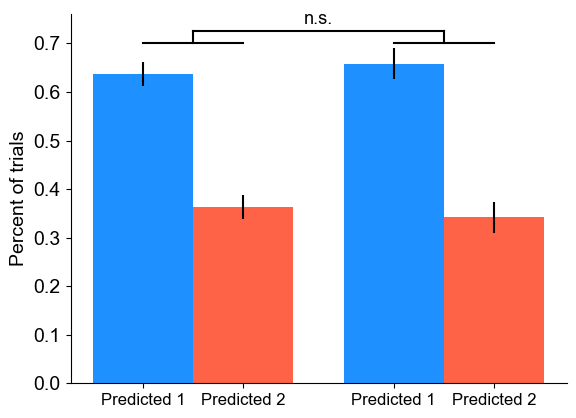

In [86]:
labels = ['Predicted 1','Predicted 2','Predicted 1','Predicted 2']
x = [.75,1.25,2,2.5]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
ax.bar(1 - width/2, single_1_mean, width, color = 'dodgerblue', yerr=single_1_sem)
ax.bar(1 + width/2, single_2_mean, width, color='tomato',yerr=single_2_sem)
ax.bar(2.25 - width/2,conj_1_mean, width, color = 'dodgerblue',yerr=conj_1_sem)
ax.bar(2.25 + width/2, conj_2_mean, width, color='tomato',yerr=conj_2_sem)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of trials', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
ax.plot([1,1],[.7,.725],c='k')
ax.plot([2.25,2.25],[.7,.725],c='k')
ax.plot([1,2.25],[.725,.725],c='k')
ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14);

# plt.savefig('pred_double_12.pdf',dpi=1000)
# plt.savefig('pred_double_12.png',dpi=1000)
plt.show()

In [84]:
import winsound
winsound.PlaySound("SystemExit",winsound.SND_ALIAS)

## 2&4

In [87]:
# get normalized prediction rates for set sizes 2&4 in single feature and single feature to conjunction anlyses
conj_ss24 = get_norm_sub_means(conj_conf,1)
single_ss24 = get_norm_sub_means(sing_conf,1)

# put into dataframe
percent_predicted = np.concatenate((single_ss24[:,0],single_ss24[:,1],conj_ss24[:,0],conj_ss24[:,1]))
feat = np.repeat(['single','conj'],40)
ss = np.repeat(['low','high','low','high'],20)

df = pd.DataFrame()
df['feat'] = feat
df['ss'] = ss
df['percent_predicted'] = percent_predicted

df.head()

,feat,ss,percent_predicted
0,single,low,0.843750
1,single,low,0.484375
2,single,low,0.781250
3,single,low,0.583333
4,single,low,0.478125


In [88]:
model = ols('percent_predicted ~ C(feat) + C(ss) + C(feat):C(ss)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(feat),1.738152e-30,1.0,7.183862e-29,1.000000e+00
C(ss),2.129966e+00,1.0,8.803249e+01,2.478252e-14
C(feat):C(ss),1.346898e-02,1.0,5.566791e-01,4.579031e-01
Residual,1.838837e+00,76.0,NaN,NaN


In [90]:
# calculate means and sem of each set size and analysis
group_means = df.groupby(['feat','ss']).mean()
group_sem = df.groupby(['feat','ss']).sem()

single_2_mean = group_means.filter(like='single',axis=0).filter(like='low',axis=0).iloc[0]
single_2_sem = group_sem.filter(like='single',axis=0).filter(like='low',axis=0).iloc[0]
single_4_mean = group_means.filter(like='single',axis=0).filter(like='high',axis=0).iloc[0]
single_4_sem = group_sem.filter(like='single',axis=0).filter(like='high',axis=0).iloc[0]
conj_2_mean = group_means.filter(like='conj',axis=0).filter(like='low',axis=0).iloc[0]
conj_2_sem = group_sem.filter(like='conj',axis=0).filter(like='low',axis=0).iloc[0]
conj_4_mean = group_means.filter(like='conj',axis=0).filter(like='high',axis=0).iloc[0]
conj_4_sem = group_sem.filter(like='conj',axis=0).filter(like='high',axis=0).iloc[0]

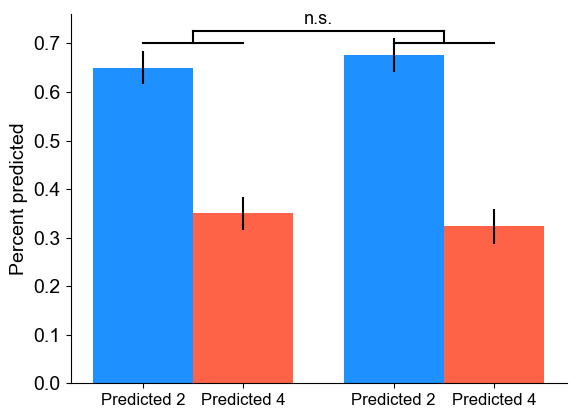

In [92]:
group_means = df.mean(axis=0)
group_se = df.sem(axis=0)
labels = ['Predicted 2','Predicted 4','Predicted 2','Predicted 4']
x = [.75,1.25,2,2.5]  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
ax.bar(1 - width/2, single_2_mean, width, color = 'dodgerblue', yerr=single_2_sem)
ax.bar(1 + width/2, single_4_mean, width, color='tomato',yerr=single_4_sem)
ax.bar(2.25 - width/2,conj_2_mean, width, color = 'dodgerblue',yerr=conj_2_sem)
ax.bar(2.25 + width/2, conj_4_mean, width, color='tomato',yerr=conj_4_sem)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent predicted', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.plot([1 - width/2,1 + width/2],[.7,.7],c='k')
ax.plot([2.25 - width/2,2.25 + width/2],[.7,.7],c='k')
ax.plot([1,1],[.7,.725],c='k')
ax.plot([2.25,2.25],[.7,.725],c='k')
ax.plot([1,2.25],[.725,.725],c='k')
ax.text(1.55,.74,'n.s.',fontsize=13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=14);

# plt.savefig('pred_double_24.pdf',dpi=1000)
# plt.savefig('pred_double_24.png',dpi=1000)
plt.show()